In [22]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

In [23]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [69]:
import numpy as np
import pandas as pd
import torch
from Models import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import plotly.express as px
import plotly.graph_objects as go

In [25]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [26]:
filepath = "RELIANCE_2010-01-012021-08-30.csv"
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2010-01-04,1075.50
1,2010-01-05,1070.70
2,2010-01-06,1088.00
3,2010-01-07,1106.05
4,2010-01-08,1103.15


In [27]:
data.tail()

,date,close
2890,2021-08-23,2162.35
2891,2021-08-24,2183.70
2892,2021-08-25,2202.60
2893,2021-08-26,2230.45
2894,2021-08-27,2227.40


In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))

fig.update_xaxes(range=["2009-11-01", "2021-11-01"])
fig.update_yaxes(range=[500, 2500])

In [29]:
TSdist = importr('TSdist')

In [30]:
def splitData(ts):

    test_set_size = int(np.round(0.2*len(ts)));
    train_set = ts[:-test_set_size]    
    test_set = ts[-test_set_size:]

    return train_set, test_set

In [31]:
#Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))

In [32]:
# Normalize the training, validation and test set

def normalize_data(train_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, test_norm

In [33]:
window_size = 20
def prepareDataForTraining(seq):

    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data 

In [34]:
train_set, test_set = splitData(data['close'].values)
train_norm, test_norm = normalize_data(train_set, test_set)

#### Block Bootsrapping - to compute different distance measures between random subset of train and test data

In [35]:
from arch.bootstrap import MovingBlockBootstrap

In [91]:
block_length = 40
num_bootstraps = 10

bs = MovingBlockBootstrap(block_length, train_set)
count = 0
train_blocked_series = []
for data in bs.bootstrap(num_bootstraps):
    count = count + 1    
    train_blocked_series.append(data[0][0])

In [92]:
bs = MovingBlockBootstrap(block_length, test_set)
count = 0
test_blocked_series = []
for data in bs.bootstrap(num_bootstraps):
    count = count + 1    
    test_blocked_series.append(data[0][0])

In [93]:
train = train_blocked_series[0]
X2 = test_blocked_series[0][:block_length]    

In [94]:
len(train_set) > len(set(train_set))

True

In [95]:
# Bootstrap 1

dtw_dist = []
indices = []

X2 = np.asarray(X2)

for i in range(0, len(train), block_length):

    X1 = train[i:i+block_length]

    ## convert to np.array
    X1 = np.asarray(X1)

    dtw = TSdist.DTWDistance(X1, X2)
    dist = dtw.item()    
    dist = "{:.2f}".format(dist)
    dtw_dist.append(dist)

    indices.append(i)    
    
finalResult = {"i" : indices,
     "DTW distance" : dtw_dist
    }

df1 = pd.DataFrame(finalResult)  

In [96]:
df1

,i,DTW distance
0,0,33981.35
1,40,48954.00
2,80,44443.70
3,120,24362.90
4,160,37031.25
5,200,31782.85
6,240,37612.35
7,280,38838.80
8,320,44576.75
9,360,43789.25


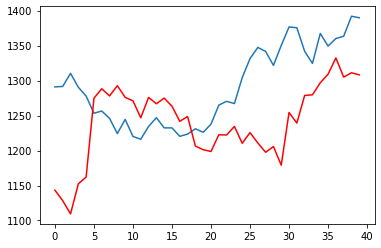

In [71]:
plt.plot(train[1680:1680+block_length])
plt.plot(X2, 'r')

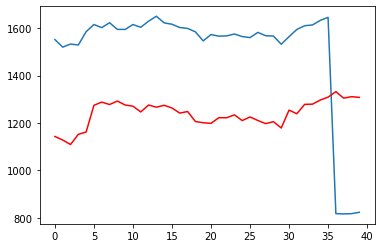

In [72]:
plt.plot(train[2040:2040+block_length])
plt.plot(X2, 'r')

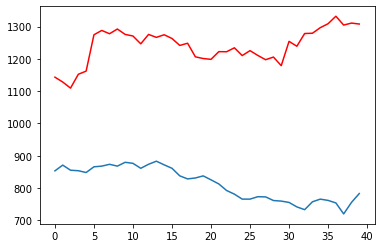

In [73]:
plt.plot(train[1240:1240+block_length])
plt.plot(X2, 'r')

In [ ]:
X1[400:400+block_length], X2[400:400+block_length]

In [55]:
x_train, y_train = prepareDataForTraining(train_norm)
x_test, y_test = prepareDataForTraining(test_norm)

x_train = np.asarray(x_train).reshape(-1, window_size, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
x_test = np.asarray(x_test).reshape(-1, window_size, 1)
y_test = np.asarray(y_test).reshape(-1, 1)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


In [56]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    


In [57]:
actual_test_len = len(test_set) - window_size

In [58]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

In [ ]:
df = pd.DataFrame({'forecasts': y_test_pred[:, 0],
                            'gt': y_test[:,0]})

In [59]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-actual_test_len:], y=y_test[:,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y= y_test_pred[:,0], mode='lines', name='predicted close price'))


fig.update_yaxes(range=[500, 2500])

#### Find distance between bootsrapped blocks using different distance measures from R and ECDF distance measures

### Dynamic Time Warping

In [60]:
dtw_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(dtw)
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "DTW distance" : dtw_dist

    }

df1 = pd.DataFrame(finalResult)

In [62]:
cort_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  # print(X2.shape)

  ## convert to np.array
  X1 = rpy2.robjects.IntVector(X1)
  X2 = rpy2.robjects.IntVector(X2)

  # print(type(X1))

  cort = TSdist.CortDistance(X1, X2, deltamethod="DTW")
  cort_dist.append(cort)
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Temporal Correlation distance" : cort_dist

    }

df3 = pd.DataFrame(finalResult)

In [64]:
fourier_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1 = rpy2.robjects.IntVector(X1)
  X2 = rpy2.robjects.IntVector(X2)

  fourier = TSdist.FourierDistance(X1, X2)
  fourier_dist.append(fourier)
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Fourier distance" : fourier_dist

    }

df4 = pd.DataFrame(finalResult)

#### KL divergence

In [101]:
def computeKLD(X1, X2, bins=2):
    values_1, edges_1 = np.histogram(X1,bins=bins,density=True)
    values_2, edges_2 = np.histogram(X2,bins=bins,density=True)
    
    #Consider only first std. deviation of original series i.e. P(x).    
    P = 0.68*values_1
    Q = values_2
    delta_x = 2/bins
    res =  np.sum( P * np.log( P/Q ) ) * delta_x
    return res

In [102]:
# Bootstrap 1

KLD = []
indices = []

X2 = np.asarray(X2)

for i in range(0, len(train), block_length):

    X1 = train[i:i+block_length]

    ## convert to np.array
    X1 = np.asarray(X1)

    kld_res = computeKLD(X1, X2)
    KLD.append(kld_res)

    indices.append(i)    
    
finalResult = {"i" : indices,
     "KL divergence" : KLD
    }

df2 = pd.DataFrame(finalResult)  

In [103]:
df2

,i,KL divergence
0,0,-0.001735
1,40,0.011923
2,80,0.001060
3,120,0.003495
4,160,0.001544
5,200,0.003614
6,240,0.006104
7,280,0.005511
8,320,0.009765
9,360,0.020540


#### Jensen Shannon Divergence

In [104]:
import scipy.stats

In [105]:
def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    if len(p)>len(q):
        p = np.random.choice(p,len(q)) # random.choice make same length to p/q
    elif len(q)>len(p):
        q = np.random.choice(q,len(p))
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    
    return scipy.stats.entropy(p,m, base=base)/2. +  scipy.stats.entropy(q, m, base=base)/2

In [106]:
# Bootstrap 1

JSD = []
indices = []

X2 = np.asarray(X2)

for i in range(0, len(train), block_length):

    X1 = train[i:i+block_length]

    ## convert to np.array
    X1 = np.asarray(X1)

    dist = jsd(X1, X2)
    JSD.append(dist)

    indices.append(i)    
    
finalResult = {"i" : indices,
     "JS divergence" : JSD
    }

df3 = pd.DataFrame(finalResult)  

In [107]:
result = pd.concat([df1, df2['KL divergence'], df3['JS divergence']], axis=1)
result

,i,DTW distance,KL divergence,JS divergence
0,0,33981.35,-0.001735,0.006090
1,40,48954.00,0.011923,0.000810
2,80,44443.70,0.001060,0.000258
3,120,24362.90,0.003495,0.000340
4,160,37031.25,0.001544,0.000149
5,200,31782.85,0.003614,0.000768
6,240,37612.35,0.006104,0.000468
7,280,38838.80,0.005511,0.000448
8,320,44576.75,0.009765,0.000545
9,360,43789.25,0.020540,0.000456
